In [1]:
import keras
from keras.datasets import boston_housing
from keras import models, layers
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape, train_targets.shape)

(404, 13) (404,)


In [4]:
# feature normalization
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
test_data -= mean

train_data /= std
test_data /= std

In [5]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(48, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(48, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [6]:
# validation set is small, use k fold validation
k = 4
num_val = len(train_data) // k
num_epochs = 100
all_scores = []
for fold in range(k):
  print("Fold ", fold)
  
  start = fold*num_val
  end = (fold+1)*num_val
  
  val_data = train_data[start:end]
  val_targets = train_targets[start:end]

  partial_train_data = np.concatenate([train_data[:start], train_data[end:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:start], train_targets[end:]], axis=0)

  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=8, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Fold  0
Fold  1
Fold  2
Fold  3


In [7]:
print(all_scores)
print(np.mean(all_scores))

[1.879201889038086, 2.4923338890075684, 2.4668023586273193, 2.4709203243255615]
2.327314615249634


In [8]:
num_epochs = 500
all_mae_histories = []
for fold in range(k):
  print('Fold ', fold)
  start = fold*num_val
  end = (fold+1)*num_val
  
  val_data = train_data[start:end]
  val_targets = train_targets[start:end]

  partial_train_data = np.concatenate([train_data[:start], train_data[end:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:start], train_targets[end:]], axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, 
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=8, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

Fold  0
Fold  1
Fold  2
Fold  3


In [9]:
average_mae_history = [np.mean([mae_fold[epoch] for mae_fold in all_mae_histories]) for epoch in range(num_epochs)]

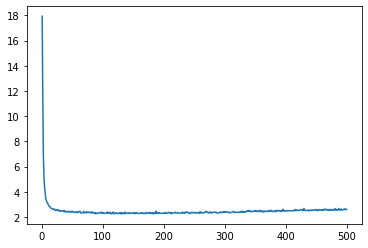

In [10]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

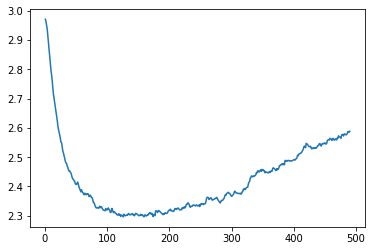

In [14]:
def smooth_data(points, factor=0.9):
  smooth_points = []
  for point in points:
    if smooth_points:
      previous = smooth_points[-1]
      smooth_points.append(previous * factor + point * (1 - factor))
    else:
      smooth_points.append(point)
  return smooth_points

smooth_mae_history = smooth_data(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)

In [15]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=100, batch_size=8, verbose=0)
test_mse, test_mae = model.evaluate(test_data, test_targets)
print(test_mse, test_mae)

4/4 [==============================] - 0s 2ms/step - loss: 15.6851 - mae: 2.6130
15.685097694396973 2.613046407699585
